# Fraud Detection Using Machine Learning
This notebook presents an end-to-end machine learning workflow for detecting fraudulent financial transactions.

The focus is on handling severe class imbalance, evaluating appropriate metrics, and selecting a model that balances fraud detection performance with operational cost.

# Dataset Description
* Source: Credit Card Fraud Dataset (Kaggle)
* Target variable: Class (1 = Fraud, 0 = Non-Fraud)
* Features include anonymized PCA components (V1–V28), Time, and Amount

Fraudulent transactions represent a very small portion of the dataset, making this a highly imbalanced classification problem.

In [25]:
import kagglehub
import os

# Download dataset
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve
)

Using Colab cache for faster access to the 'creditcardfraud' dataset.


In [26]:
csv_path = os.path.join(path, "creditcard.csv")
df = pd.read_csv(csv_path)

df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Data Loading & Validation
In this section, we load the dataset and perform basic validation checks to ensure data integrity before analysis.

In [27]:
df.shape


(284807, 31)

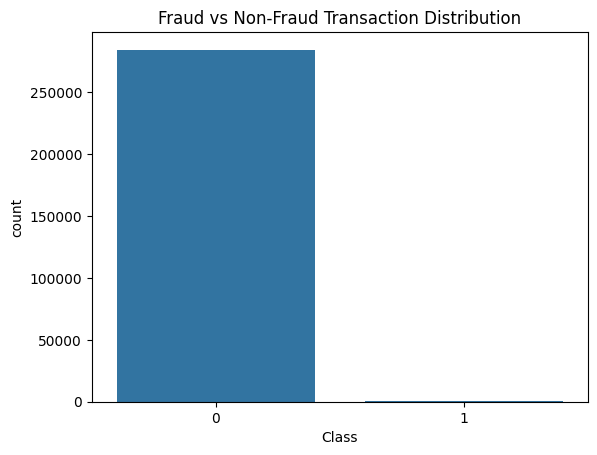

In [28]:
sns.countplot(x="Class", data=df)
plt.title("Fraud vs Non-Fraud Transaction Distribution")
plt.show()


#Exploratory Data Analysis (EDA)
The goal of EDA is to understand data distribution, class imbalance, and potential modeling challenges.

#Results
Fraudulent transactions account for less than 1% of observations, confirming severe class imbalance. As a result, accuracy alone is not a reliable metric for model evaluation.

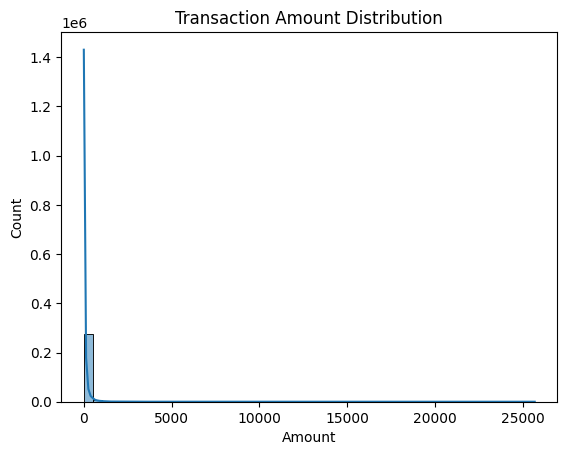

In [29]:
sns.histplot(df["Amount"], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()


In [30]:
X = df.drop("Class", axis=1)
y = df["Class"]

X.shape, y.shape


((284807, 30), (284807,))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

y_train.value_counts(normalize=True)


,proportion
Class,
0,0.998271
1,0.001729


#Preprocessing
Steps:

* Separate features and target
* Train/test split using stratify=y to preserve class ratio
* Scaling is not applied as tree-based models do not require it

In [32]:
lr = LogisticRegression(max_iter=1000, n_jobs=-1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.68      0.76        98

    accuracy                           1.00     56962
   macro avg       0.92      0.84      0.88     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC: 0.9483689332514098


#Baseline Model: Logistic Regression
Logistic Regression serves as an interpretable baseline model. Given the class imbalance, recall and ROC AUC are emphasized over accuracy.

#Results
The baseline model achieves high precision but moderate recall, indicating that a significant number of fraudulent transactions remain undetected.

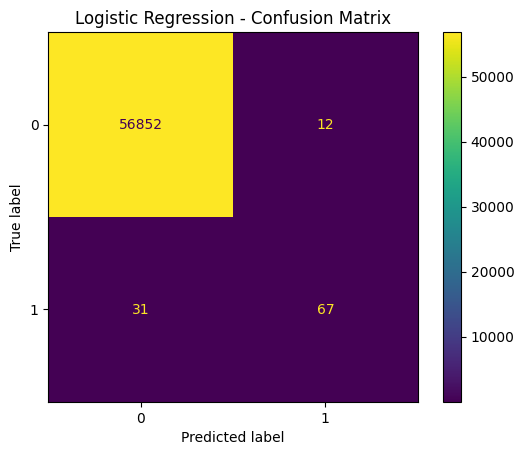

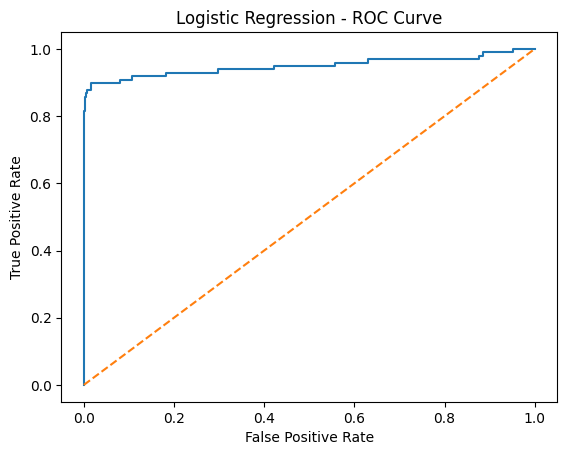

In [33]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("Logistic Regression - ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


#Confusion Matrix Interpretation:
The baseline Logistic Regression model achieves high precision but moderate recall. While false positives are minimal, a non-trivial number of fraudulent transactions remain undetected. This trade-off motivates further techniques to handle class imbalance and improve recall.

#ROC Curve Analysis:
The ROC curve demonstrates strong discriminatory power, with the model achieving high true positive rates at low false positive rates. This suggests that probability outputs from Logistic Regression are informative and suitable for threshold tuning based on business risk tolerance.

In [34]:
lr_bal = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight="balanced"
)

lr_bal.fit(X_train, y_train)

y_pred_bal = lr_bal.predict(X_test)
y_prob_bal = lr_bal.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_bal))
print("ROC AUC (balanced):", roc_auc_score(y_test, y_prob_bal))


              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

ROC AUC (balanced): 0.972231633227292


#Balanced Logistic Regression Results:
Applying class weighting significantly increased fraud recall, capturing over 90% of fraudulent transactions. However, this improvement comes at the cost of precision, leading to a higher false positive rate. This trade-off highlights the operational balance between fraud prevention and review cost, emphasizing the importance of threshold tuning and business context.

In [35]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC AUC (RF):", roc_auc_score(y_test, y_prob_rf))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.74      0.84        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC (RF): 0.947053944678603


#Model Comparison:
Logistic Regression provided a strong interpretable baseline but struggled with recall under severe class imbalance. Applying class weighting significantly improved recall but resulted in excessive false positives. The Random Forest model achieved the best balance between precision and recall, capturing the majority of fraud cases while maintaining a low false positive rate. This trade-off makes it the most suitable model for practical fraud detection systems.

#Model Limitations & Bias
* Severe class imbalance may still bias predictions
* False positives introduce manual review costs
* Model performance may degrade due to data drift
* Predictions should support, not replace, human decision-making
#Conclusion
This project demonstrates a complete fraud detection workflow, from data validation to model selection. It highlights the importance of metric choice, class imbalance handling, and interpretability in real-world AI systems.